In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns 
from math import sqrt
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, GroupKFold, LeaveOneGroupOut, GroupShuffleSplit, TimeSeriesSplit

%matplotlib inline 
plt.style.use('bmh')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
import matplotlib.dates as md
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
import matplotlib.ticker as ticker
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Load Data
Data are from the kaggle competition [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy).

The task is to forecast, as precisely as possible, the unit sales (demand) of various products sold in the USA by Walmart.

For this demonstration, I will use a portion of this data.

In [2]:
data = pd.read_csv('data_for_tsa.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,sell_price,year,month,dayofweek
0,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,2011-01-29,1.48,2011,1,5
1,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,85,2011-01-30,1.48,2011,1,6
2,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,47,2011-01-31,1.48,2011,1,0
3,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,56,2011-02-01,1.48,2011,2,1
4,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,51,2011-02-02,1.48,2011,2,2


In [3]:
train = data[data['date'] <= '2015-04-24']
test = data[(data['date'] > '2015-04-11') & (data['date'] <= '2016-04-24')]

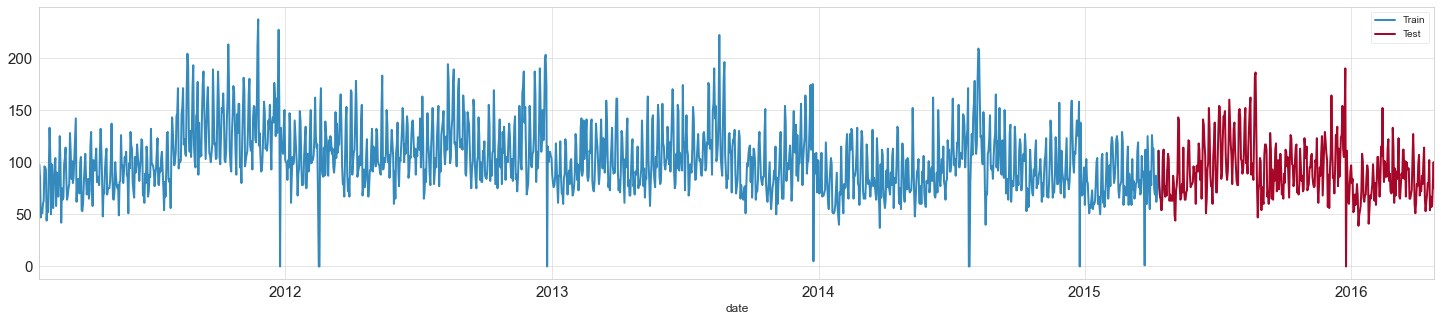

In [4]:
fig, ax = plt.subplots(figsize=(25,5))
train.plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);

## Create Some Features

In [5]:
def lags_windows(df):
    lags = [7]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","demand"]].groupby("id")["demand"].shift(lag)

    wins = [7]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def per_timeframe_stats(df, col):
    #For each item compute its mean and other descriptive statistics for each month and dayofweek in the dataset
    months = df['month'].unique().tolist()
    for y in months:
        df.loc[df['month'] == y, col+'_month_mean'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['month'] == y, col+'_month_max'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
        df.loc[df['month'] == y, col+'_month_min'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.min()).astype("float32")
        df[col + 'month_max_to_min_diff'] = (df[col + '_month_max'] - df[col + '_month_min']).astype("float32")

    dayofweek = df['dayofweek'].unique().tolist()
    for y in dayofweek:
        df.loc[df['dayofweek'] == y, col+'_dayofweek_mean'] = df.loc[df['dayofweek'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['dayofweek'] == y, col+'_dayofweek_median'] = df.loc[df['dayofweek'] == y].groupby(['id'])[col].transform(lambda x: x.median()).astype("float32")
        df.loc[df['dayofweek'] == y, col+'_dayofweek_max'] = df.loc[df['dayofweek'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
    return df

def feat_eng(df):
    df = lags_windows(df)
    df = per_timeframe_stats(df,'demand')
    return df

In [6]:
train = feat_eng(train)
train = train.dropna() 
test = feat_eng(test)
test = test.dropna() 

In [7]:
useless_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','demand','date','demand_month_min']
train_cols = train.columns[~train.columns.isin(useless_cols)]
print('Training columns:',[x for x in train_cols])
X_train = train[train_cols].copy()
Y_train = train["demand"].ravel()
X_test = test[train_cols].copy()

X_train = X_train.values
X_test = X_test.values

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 1337 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

Training columns: ['sell_price', 'year', 'month', 'dayofweek', 'lag_7', 'rmean_7_7', 'demand_month_mean', 'demand_month_max', 'demandmonth_max_to_min_diff', 'demand_dayofweek_mean', 'demand_dayofweek_median', 'demand_dayofweek_max']


## Define Cross Validation and Plotting Functions

In [8]:
def cross_validation(X_train, X_test, Y_train, folds=5, model_type='rf', groups=None, n_folds=NFOLDS):
    train_folds, test_folds = [],[]
    oof = np.zeros(ntrain)
    prediction = np.zeros(ntest)
    scores = []

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train,Y_train, groups=groups)):
        #print(train_index,valid_index)
        train_folds.append(train_index)
        test_folds.append(valid_index)     
        
        x_train, x_valid = X_train[train_index], X_train[valid_index]
        y_train, y_valid = Y_train[train_index], Y_train[valid_index]
        if model_type == 'rf':
            model = RandomForestRegressor(min_weight_fraction_leaf=0.05, n_jobs=-2,random_state=0, max_depth=4, n_estimators=100)
            model.fit(x_train, y_train)
            y_pred_valid = model.predict(x_valid)
            y_pred = model.predict(X_test)              
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(sqrt(mean_squared_error(y_valid, y_pred_valid)))
        prediction += y_pred          

    prediction /= n_folds        
    print('CV mean score: \t\t    {0:.5f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    return oof, prediction, np.mean(scores), model, train_folds, test_folds    

def oos_score(actual,prediction):
    print('Out of sample (test) score: {:.6f}'.format(sqrt(mean_squared_error(actual, prediction))))
    return sqrt(mean_squared_error(actual, prediction))

def plot_cv(plot_title):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]},figsize=(25,5))
    colors = ["#f7bb05","#2e2b23"]
    sns.set_palette(sns.color_palette(colors))

    for i in range(len(train_folds)):
        folds = pd.DataFrame()
        folds_train = pd.DataFrame(data=train.iloc[train_folds[i]][['date','demand']]);folds_train['Fold Number'] = i;folds_train['type']='train'
        folds = folds.append(folds_train)
        folds_test = pd.DataFrame(data=train.iloc[test_folds[i]][['date','demand']]);folds_test['Fold Number'] = i;folds_test['type']='test'
        folds = folds.append(folds_test)
        if (i==len(train_folds)-1):
            legend_ = 'brief'
        else:
            legend_ = False
        sns.scatterplot(x='date',y='Fold Number',data=folds,hue='type',legend=legend_,marker='|',s=300,alpha=1,linewidth=1,ax=ax[0])
        sns.distplot(folds_test['demand'],color='#db6521',hist=True,ax=ax[1])
    sns.distplot(test['demand'],color='#2680c9',hist=True,ax=ax[1])
    ax[0].set_xlabel('date', fontsize = 18, fontdict=dict(weight='bold')); ax[0].set_ylabel('Fold Number', fontsize = 18, fontdict=dict(weight='bold'))
    ax[0].set_title(plot_title, fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax[0].set(xlim=(train['date'].astype(str).min(), train['date'].astype(str).max()))
    ax[0].xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(120));    
    ax[1].set_title('Fold Validation vs Actual Test Distribution', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    fig.tight_layout()

In [9]:
stats = pd.DataFrame(columns=['K-Fold Variation','CV-RMSE','TEST-RMSE'])

## 1. K-Fold Cross Validation - No Shuffle
In the bibliography it is known and not advised to use this type of CV for time series data, because it ignores the coherence in the data. Remember that the actual test data is a period in the future.

CV mean score: 		    23.64240, std: 1.8744.
Out of sample (test) score: 20.455980


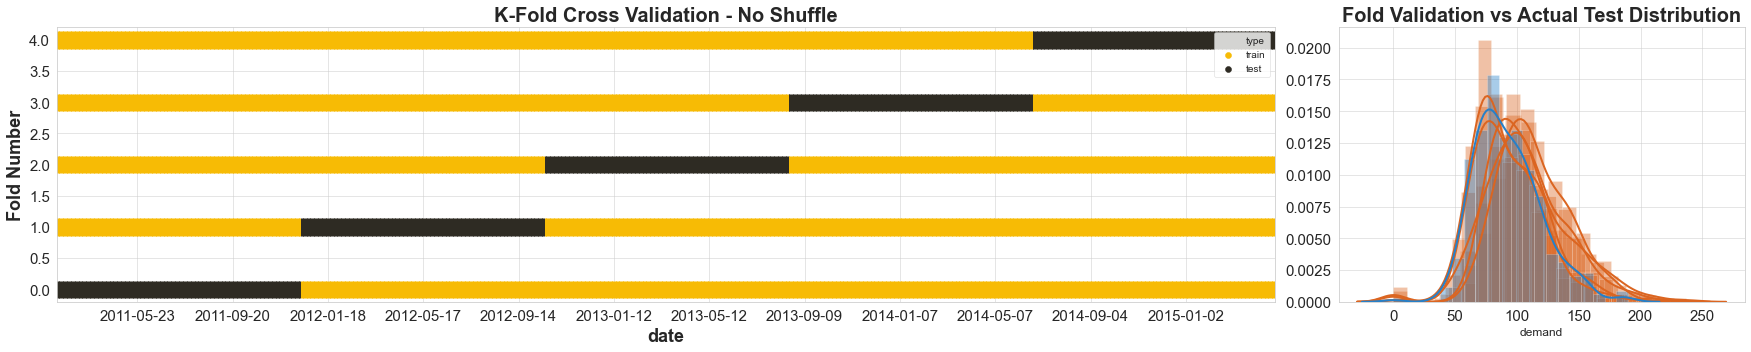

In [10]:
kfolds_suffleFalse = KFold(n_splits= NFOLDS, random_state=SEED, shuffle=False) 
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=kfolds_suffleFalse, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'K-Fold Cross Validation - No Shuffle', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('K-Fold Cross Validation - No Shuffle')

## 2. K-Fold Cross Validation - Shuffle
The one fifth of the data is again the validation set in each iteration, but this time it is randomly distributed in the whole data. As in the previous, each sample that is used as validation in one iteration, will never be used as validation in another.

CV mean score: 		    22.59125, std: 1.7155.
Out of sample (test) score: 20.526280


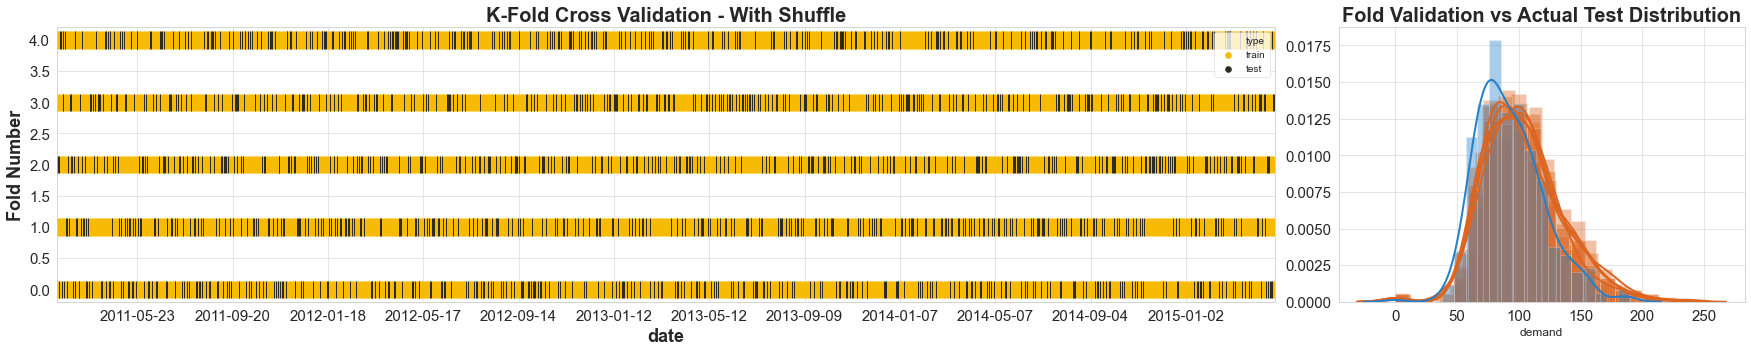

In [11]:
kfolds_suffleTrue = KFold(n_splits= NFOLDS, random_state=SEED, shuffle=True)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=kfolds_suffleTrue, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'K-Fold Cross Validation - Shuffle', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('K-Fold Cross Validation - With Shuffle')

## 3. Random Permutation Cross Validation
ShuffleSplit will randomly sample the entire dataset during each iteration to generate a training set and a validation set. The test_size and train_size parameters control how large the validation and training set should be for each iteration. Since we are sampling from the entire dataset during each iteration, values selected during one iteration, could be selected **again** during another iteration.

Since some data are not included in the training, this method is faster than normal k fold cross validation.

CV mean score: 		    22.47461, std: 2.2129.
Out of sample (test) score: 20.630861


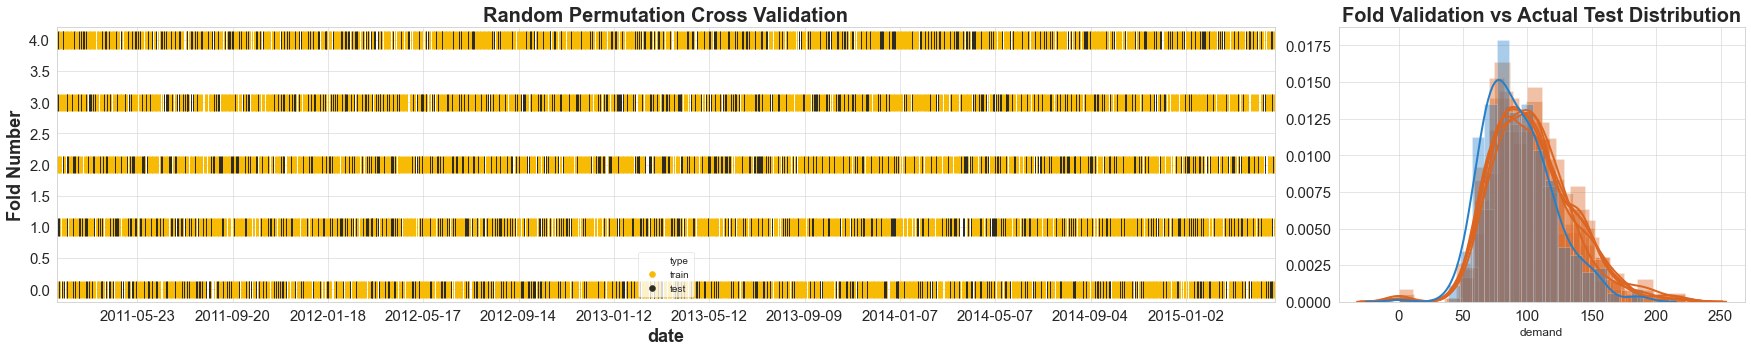

In [12]:
kfolds_shuffleSplit = ShuffleSplit(n_splits= NFOLDS, random_state=SEED, train_size=0.7, test_size=0.2)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=kfolds_shuffleSplit, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Random Permutation Cross Validation', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Random Permutation Cross Validation')

## 4. Stratified K-Fold Cross Validation - No Shuffle
Like normal K-Fold, but each fold contains approximately the same percentage of samples for each target. Better used with classification rather than regression.

CV mean score: 		    22.73248, std: 0.4955.
Out of sample (test) score: 20.599119


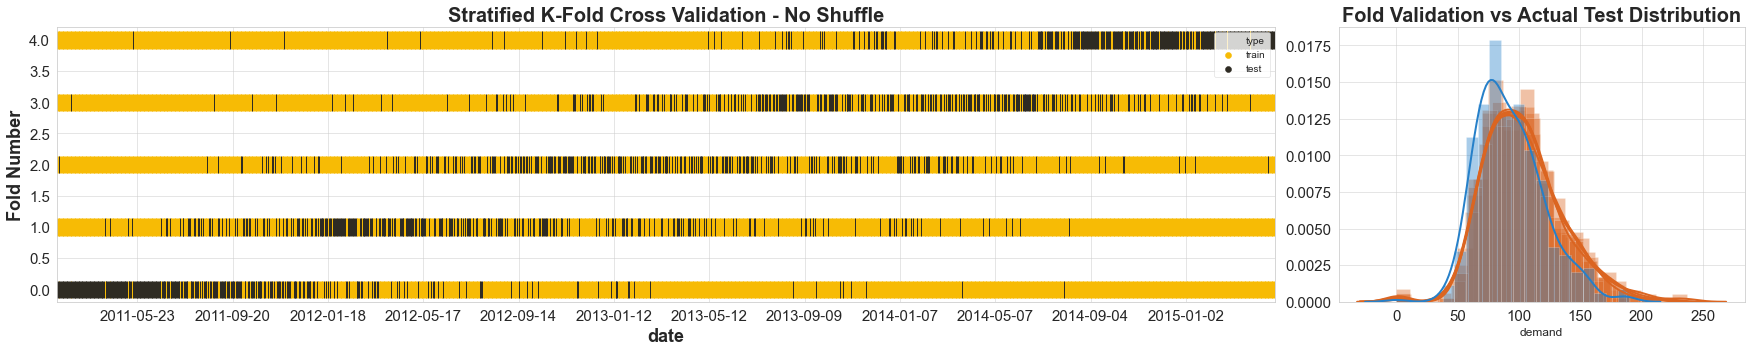

In [13]:
strfolds_suffleFalse = StratifiedKFold(n_splits= NFOLDS, random_state=SEED, shuffle=False)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=strfolds_suffleFalse, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Stratified K-Fold Cross Validation - No Shuffle', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Stratified K-Fold Cross Validation - No Shuffle')

## 5. Stratified K-Fold Cross Validation - With Shuffle
The folds contain approximately the same percentage of samples for each target, but first the data is shuffled.

CV mean score: 		    22.46089, std: 1.2560.
Out of sample (test) score: 20.577140


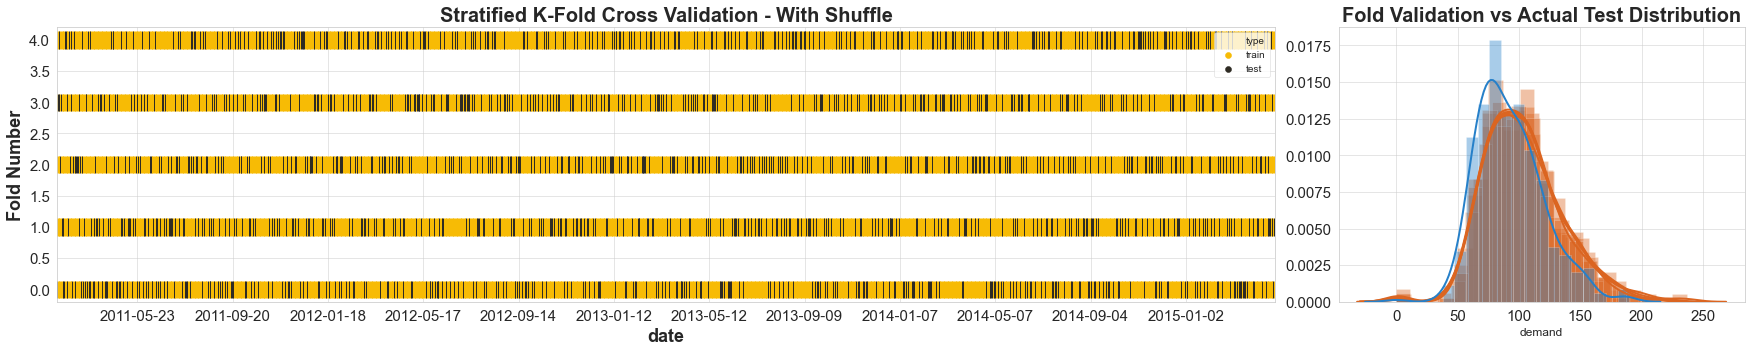

In [14]:
strfolds_suffleTrue = StratifiedKFold(n_splits= NFOLDS, random_state=SEED, shuffle=True)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=strfolds_suffleTrue, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Stratified K-Fold Cross Validation - With Shuffle', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Stratified K-Fold Cross Validation - With Shuffle')

## 6. Grouped K-Fold
We can define groups from another column of the dataset. The same group is ensured not to be in both training and validation sets.

CV mean score: 		    23.21066, std: 2.7148.
Out of sample (test) score: 20.550477


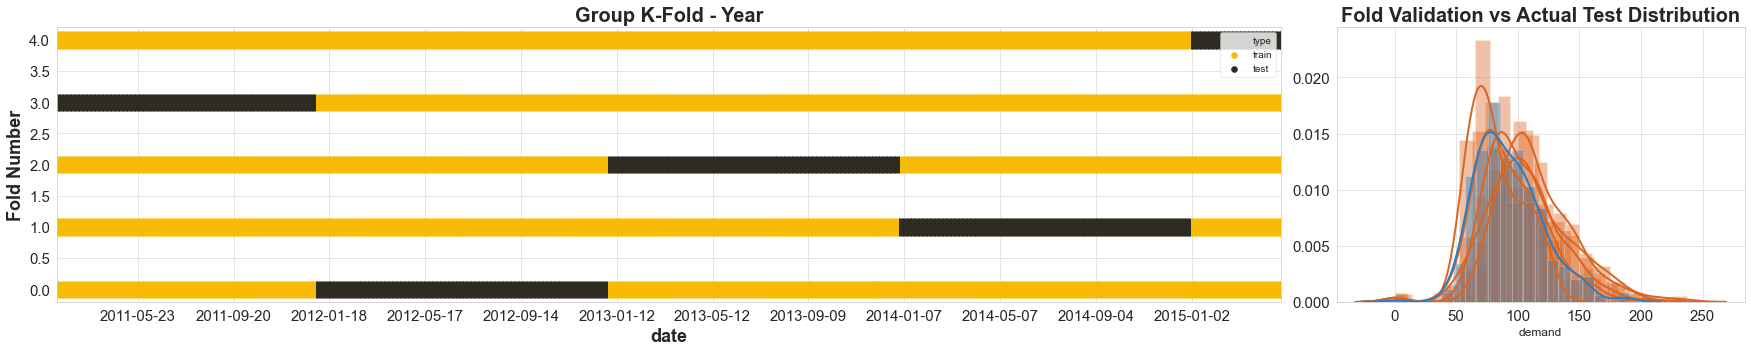

In [15]:
groups = train['year'].tolist()
groupfolds = GroupKFold(n_splits=NFOLDS)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=groupfolds, model_type='rf', groups=groups)
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Grouped K-Fold - Year', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Group K-Fold - Year')

We used year as groups in the previous example, and months in the next.

CV mean score: 		    22.32342, std: 3.9974.
Out of sample (test) score: 20.481986


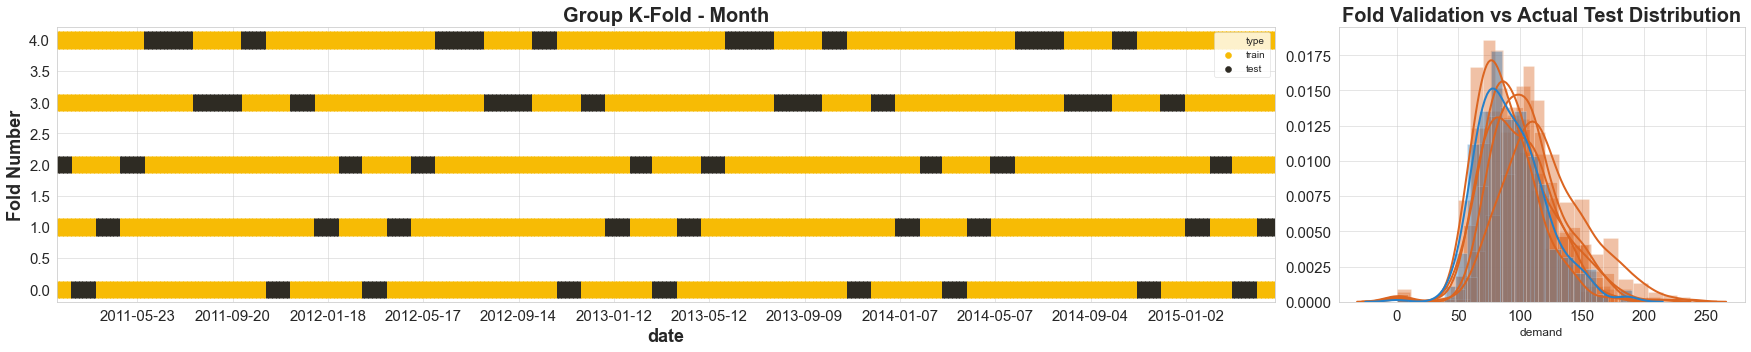

In [16]:
groups = train['month'].tolist()
groupfolds = GroupKFold(n_splits=NFOLDS)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=groupfolds, model_type='rf', groups=groups)
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Grouped K-Fold - Month', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Group K-Fold - Month')

## 7. Grouped K-Fold - Leave One Group Out
In each iteration the model is trained with samples of all groups but one. In the case of the months as groups, 12 iterations are performed.

CV mean score: 		    22.48503, std: 5.6201.
Out of sample (test) score: 20.468222


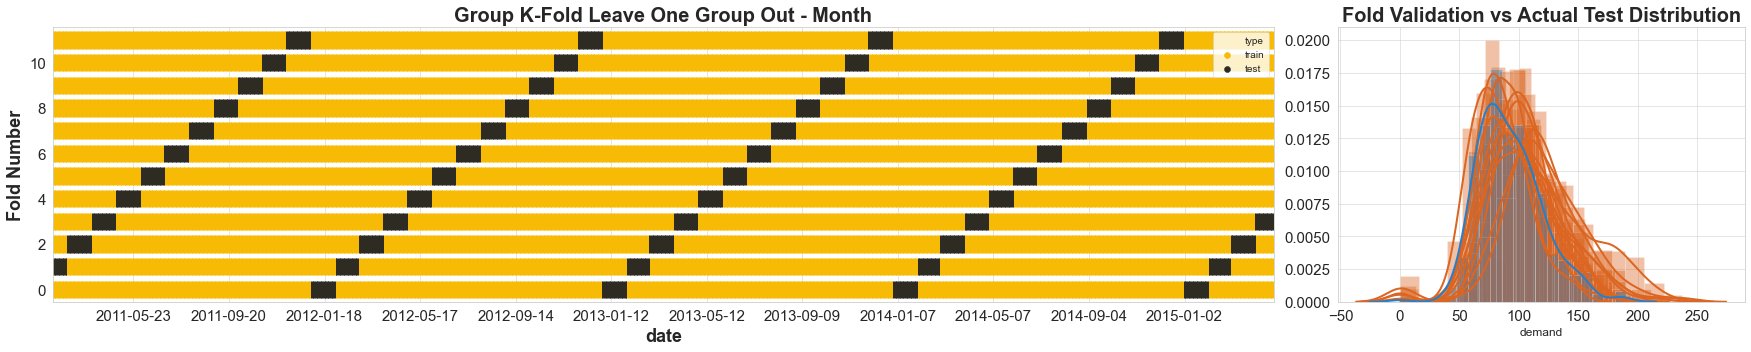

In [17]:
groups = train['month'].tolist()
n_folds = train['month'].nunique()
logroupfolds = LeaveOneGroupOut()
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=logroupfolds, model_type='rf', groups=groups, n_folds=n_folds)
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Group K-Fold Leave One Group Out - Month', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Group K-Fold Leave One Group Out - Month')

## 8. Grouped K-Fold with Random Permutation
This is a combination of two methods. We define groups and also randomly sample the entire dataset during each iteration to generate a training set and a validation set.

CV mean score: 		    21.58829, std: 2.5721.
Out of sample (test) score: 20.365067


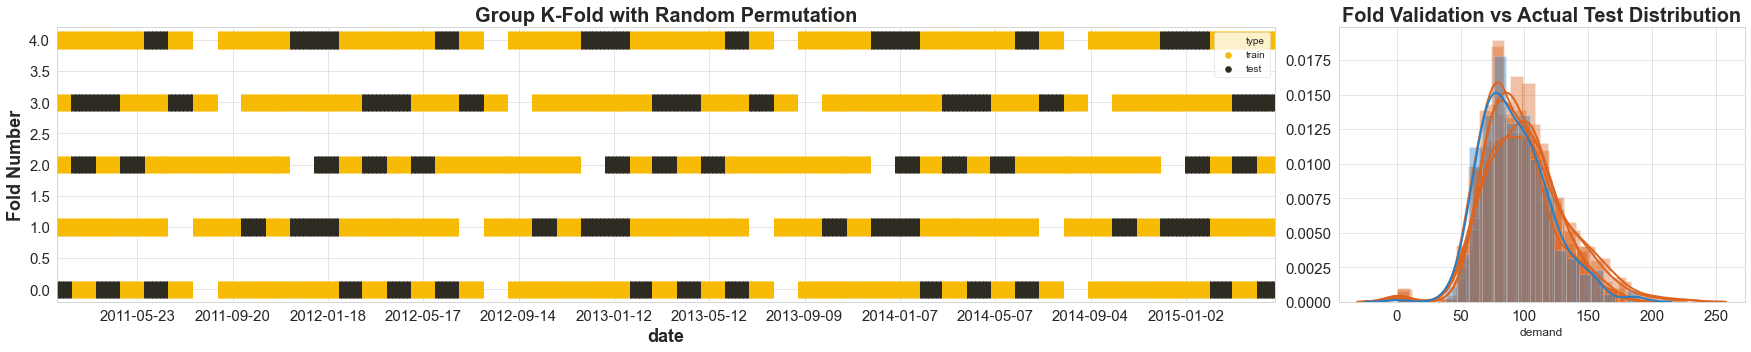

In [18]:
groups = train['month'].tolist()
rpgroupfolds = GroupShuffleSplit(n_splits=NFOLDS,train_size=0.7, test_size=0.2, random_state=SEED)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=rpgroupfolds, model_type='rf', groups=groups)
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Group K-Fold with Random Permutation', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Group K-Fold with Random Permutation')

## 9. Time Series Split
The methods that follow are advised to be used with time series data. 

In time series split the traning set is always divided in two parts. The first part is always the training set, while the latter part is the validation set. The length of the validation set stays the same, while training set is becoming bigger and bigger with each iteration.

CV mean score: 		    24.32591, std: 2.0312.
Out of sample (test) score: 20.999613


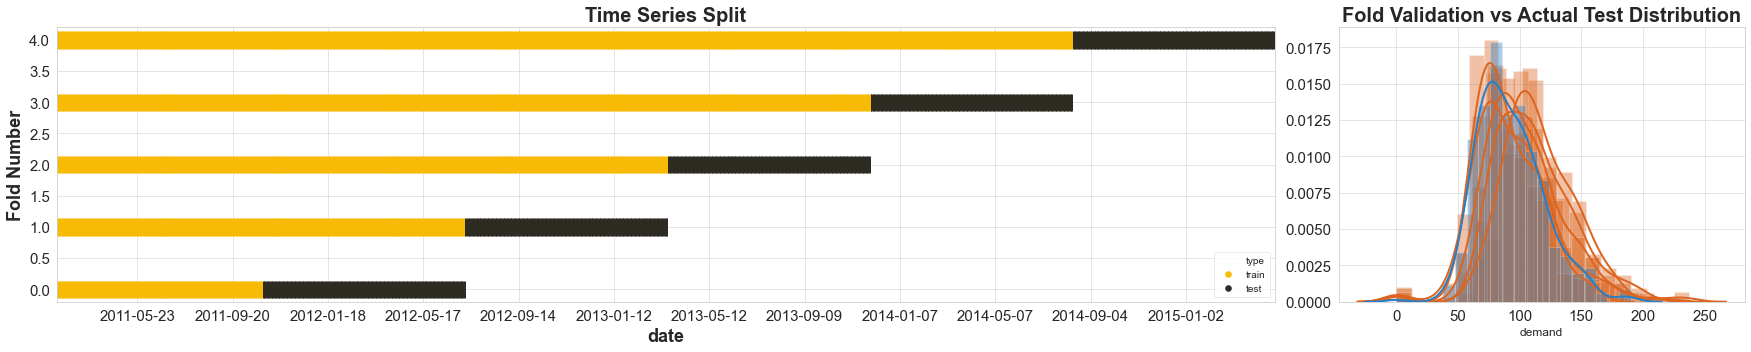

In [19]:
timeSeriesSplit = TimeSeriesSplit(n_splits= NFOLDS)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=timeSeriesSplit, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Time Series Split', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Time Series Split')

## 10. Blocking Time Series Split
The train and validation sets are unique in each iteration. No value is used twice. Train set is always before validation. Being trained in fewer samples, it is also faster than other cross validation methods.

In [20]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.9 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

CV mean score: 		    22.57081, std: 6.0085.
Out of sample (test) score: 19.896889


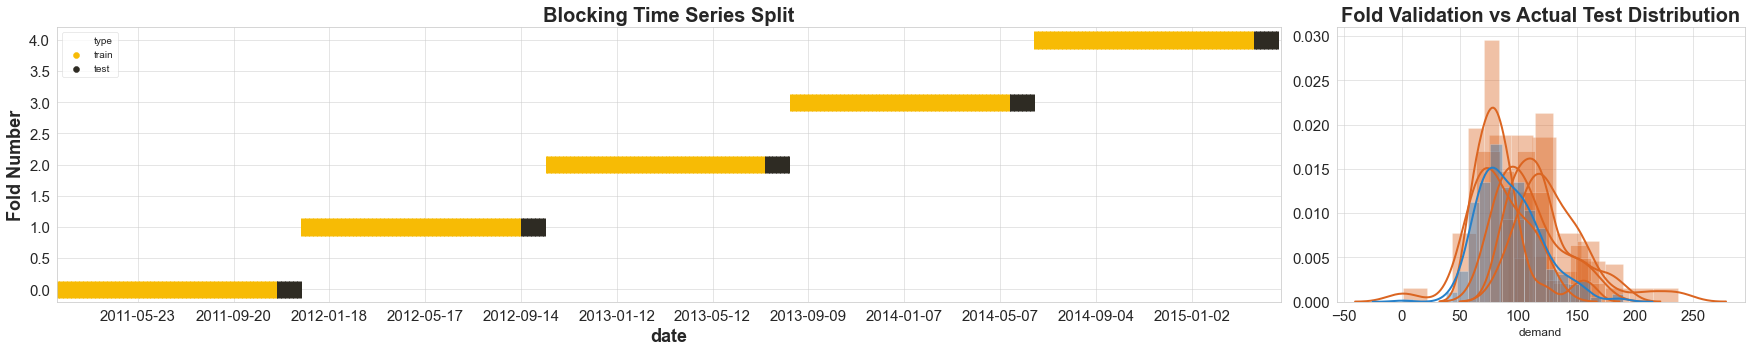

In [21]:
btscv = BlockingTimeSeriesSplit(n_splits=NFOLDS)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=btscv, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Blocking Time Series Split', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Blocking Time Series Split')

## Bonus: 11. Purged Cross Validation
In each iteration, before and after the training set, we remove some samples.

In [22]:
class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    '''
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.1):
        if not isinstance(t1, pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo


    def split(self,X,y=None,groups=None):
        X = pd.DataFrame(X)
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i,j in test_starts:
            t0 = self.t1.index[i] # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx < X.shape[0]: # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

CV mean score: 		    23.64854, std: 1.9370.
Out of sample (test) score: 20.589597


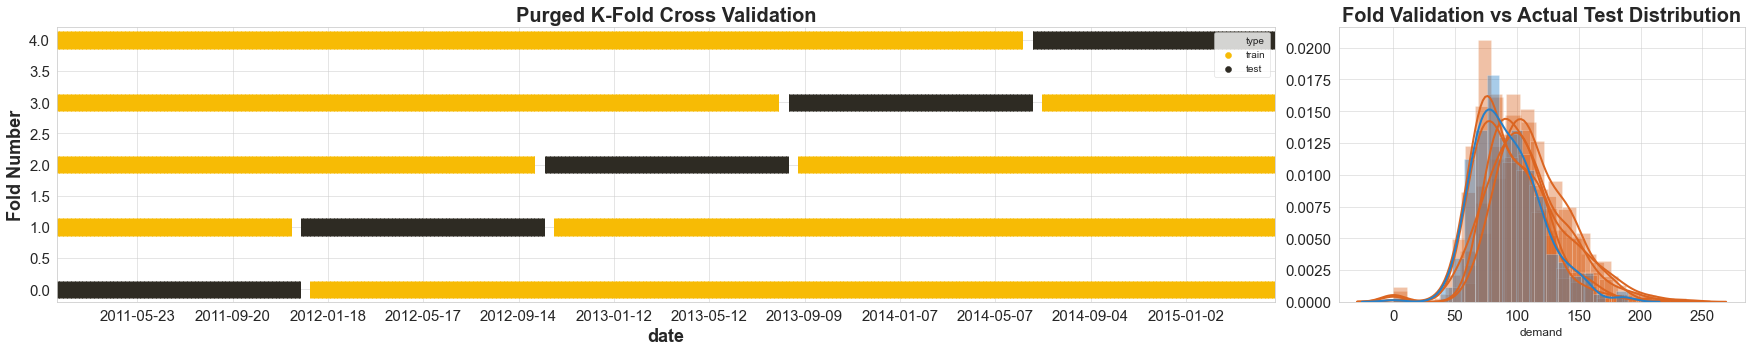

In [23]:
cont = pd.Series(train.index)
purgedfolds=PurgedKFold(n_splits=NFOLDS,t1=cont,pctEmbargo=0.0)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=purgedfolds, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Purged K-Fold Cross Validation', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Purged K-Fold Cross Validation')

Setting embargo to a value greater than 0, we remove extra samples after the validation set.

CV mean score: 		    23.87267, std: 1.7693.
Out of sample (test) score: 20.414387


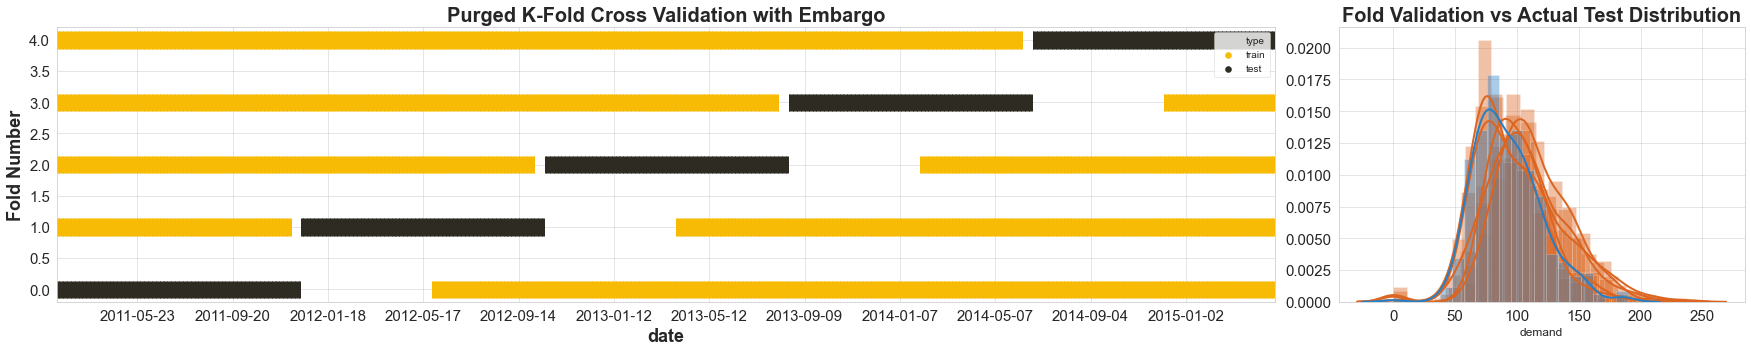

In [24]:
cont = pd.Series(train.index)
purgedfolds=PurgedKFold(n_splits=NFOLDS,t1=cont,pctEmbargo=0.1)
oof, prediction, cv_score, model, train_folds, test_folds =  cross_validation(X_train, X_test, Y_train, folds=purgedfolds, model_type='rf')
a = oos_score(test['demand'].values,prediction)
stats = stats.append({'K-Fold Variation':'Purged K-Fold Cross Validation with Embargo', 'CV-RMSE':cv_score, 'TEST-RMSE':a},ignore_index=True)
plot_cv('Purged K-Fold Cross Validation with Embargo')

In [25]:
cm = sns.light_palette("green", as_cmap=True, reverse=True)
stats.style.background_gradient(cmap=cm)

,K-Fold Variation,CV-RMSE,TEST-RMSE
0,K-Fold Cross Validation - No Shuffle,23.6424,20.456
1,K-Fold Cross Validation - Shuffle,22.5913,20.5263
2,Random Permutation Cross Validation,22.4746,20.6309
3,Stratified K-Fold Cross Validation - No Shuffle,22.7325,20.5991
4,Stratified K-Fold Cross Validation - With Shuffle,22.4609,20.5771
5,Grouped K-Fold - Year,23.2107,20.5505
6,Grouped K-Fold - Month,22.3234,20.482
7,Group K-Fold Leave One Group Out - Month,22.485,20.4682
8,Group K-Fold with Random Permutation,21.5883,20.3651
9,Time Series Split,24.3259,20.9996
